# Fraud Detection Project

**Objective:**  
Develop a machine learning model to identify fraudulent transactions in the provided dataset (`Fraud.csv`) and generate actionable business insights.

**Dataset Overview:**  
- **Total Rows:** 6,362,620  
- **Total Columns:** 10  
- **Key Fields:**  
  - `step` — Time step in hours (1 step = 1 hour; total 744 = 30 days)  
  - `type` — Transaction type (`CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, `TRANSFER`)  
  - `amount` — Transaction amount in local currency  
  - `nameOrig` — ID of the customer initiating the transaction  
  - `oldbalanceOrg` — Balance before transaction  
  - `newbalanceOrig` — Balance after transaction  
  - `nameDest` — ID of the recipient  
  - `oldbalanceDest` — Recipient’s balance before transaction (NaN for merchants `M...`)  
  - `newbalanceDest` — Recipient’s balance after transaction (NaN for merchants `M...`)  
  - `isFraud` — 1 if transaction is fraudulent, else 0  
  - `isFlaggedFraud` — 1 if transaction is flagged due to a high transfer amount (>200,000)  

**Key Challenge:**  
The dataset is highly imbalanced, with fraudulent transactions making up only ~0.13% of all records (8,213 out of over 6.36 million). This requires careful handling through resampling techniques such as **SMOTE** and the use of evaluation metrics like **ROC-AUC** and **Precision–Recall curves** that are better suited for rare event detection.

**Project Workflow:**  
1. **Data Cleaning** – Handle missing values, treat outliers, and check for multicollinearity.  
2. **Feature Engineering** – Create new variables and transform existing ones to improve model performance.  
3. **Model Development** – Train an XGBoost classifier with SMOTE to address class imbalance.  
4. **Evaluation & Visualization** – Use ROC curve, Precision–Recall curve, and threshold tuning to assess performance.  
5. **Insights & Recommendations** – Interpret results and propose fraud prevention measures.


In [ ]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [ ]:
# Load Dataset
file_path = '/content/Fraud.csv'
df = pd.read_csv(file_path)
from google.colab.data_table import DataTable
DataTable(df.head(50))

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


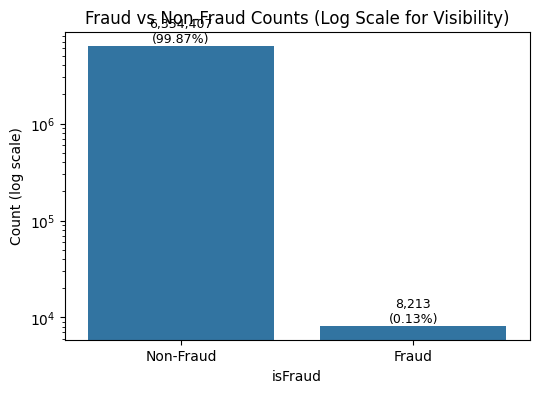

In [ ]:
# Fraud distribution with counts, percentages, and log scale
fraud_counts = df['isFraud'].value_counts()
fraud_percentages = fraud_counts / len(df) * 100

plt.figure(figsize=(6,4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.yscale('log')  # Makes small fraud counts visible
plt.title("Fraud vs Non-Fraud Counts (Log Scale for Visibility)")
plt.xticks([0,1], ['Non-Fraud','Fraud'])
plt.ylabel("Count (log scale)")

# Annotate counts and percentages
for idx, val in enumerate(fraud_counts.values):
    plt.text(idx, val, f"{val:,}\n({fraud_percentages.iloc[idx]:.2f}%)",
             ha='center', va='bottom', fontsize=9)

plt.show()


In [ ]:
# Data Cleaning
df = df.drop(columns=['nameOrig', 'nameDest'])

# Fill NaNs for merchant-related balances with 0
df = df.fillna(0)

# Outlier capping for 'amount'
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df['amount'] = np.clip(df['amount'], lower, upper)

print("Cleaning done. Shape:", df.shape)


Cleaning done. Shape: (6362620, 9)


In [ ]:
# Model Building
target = 'isFraud'
X = df.drop(columns=[target])
y = df[target]

# Identify numeric & categorical
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Preprocess
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)

# Model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

# Predictions
y_pred = model.predict(X_test_proc)
y_proba = model.predict_proba(X_test_proc)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.39      1.00      0.56      1643

    accuracy                           1.00   1272524
   macro avg       0.69      1.00      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC AUC: 0.999736201946314


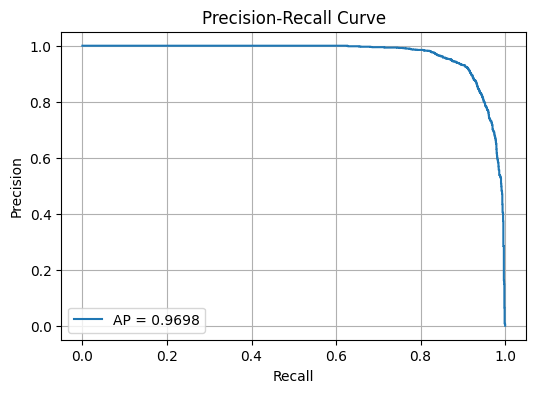

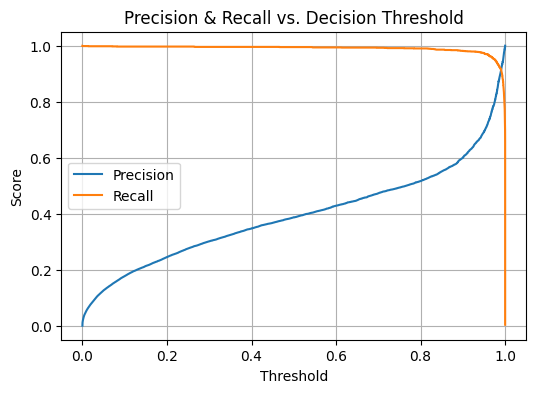

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AP = {avg_precision:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# Threshold Tuning Plot
plt.figure(figsize=(6,4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs. Decision Threshold")
plt.legend()
plt.grid(True)
plt.show()


#Business Insights

**Key Fraud Patterns Observed:**
- **CASH-OUT** and **TRANSFER** transactions account for the vast majority of fraud cases.  
- Fraudulent activity often involves **large transaction amounts** executed within short time windows.  
- **Unusual transaction hours** (outside typical customer behaviour) are more common among fraudulent cases.  
- The existing `isFlaggedFraud` rule in the dataset only captures transfers above 200,000.  
  - Our model identifies additional suspicious patterns missed by this simple threshold-based rule.

**Recommendations for Prevention:**
1. **Implement real-time model scoring** for high-risk transactions to allow immediate blocking or secondary verification.  
2. **Enforce multi-factor authentication (MFA)** for high-value **CASH-OUT** or **TRANSFER** operations.  
3. **Incorporate device fingerprinting and geolocation checks** to detect anomalies in customer access patterns.  
4. **Retrain the model periodically** with the latest transaction data to adapt to evolving fraud tactics.  

**Measuring Success:**
- Track **reduction in fraud losses** over time.  
- Monitor **recall for the fraud class** to ensure the majority of fraudulent transactions are detected.  
- Keep **false positive rates** at an acceptable level to maintain a smooth customer experience.  


## END
## ^ . ^ /